#SIMULATED ANNEALING

##Problem: find a minimum of a given function

The point of simulated annealing is that it performs kind of constrained random search.

It is done in few loops. Pseudocode:

In [4]:
state = random_state()

while not is_frozen():
    while not is_equilibrium():
        new_state = random_move()
        if (is_acceptable(new_state)):
            state = new_state
    reduce_temperature()

Parameters that can be distinguished are:

* **temperature** - determines probability of acceptance for uphill moves
* **acceptance function** - determines criteria for accepting downhill and uphill moves
* **cooling schedule** - different ways of reducing the temperature, ie.
    * geometric reduction: after reaching each state of equilibrium the temperature is multiplied by a constant $c \in [0, 1]$
* **ways of reaching equilibrium** - how to decide when to reduce the temperature
    * constant number of steps between equilibria

#Full example

In [1]:
import matplotlib
from pylab import *
import numpy as np
matplotlib.use('PS')
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


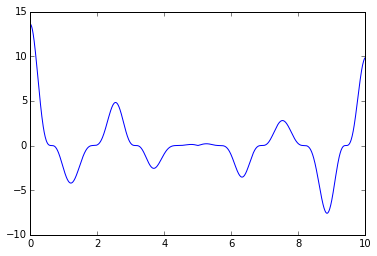

In [2]:
def f(x):
    return np.exp(np.cos(x)**2) * np.cos(2.5*x)**3 * np.abs(x-5)

x = np.linspace(0,10, 1000)
y = f(x)
plt.plot(x, y)

In [17]:
import random

TEMPERATURE = 10
TEMP_REDUCTION_FACTOR = 0.5
STEPS_TO_EQUILIBRIUM = 10
state = 0.0
STEPS = 0

def random_state():
    return random.random() * 10

def random_move():
    global TEMPERATURE, state
    return random_state()
    #return state + (-0.5*random_state()) * 0.1*TEMPERATURE

def acc_func(x, new_x):
    global TEMPERATURE
    return np.exp( (f(x) - f(new_x))/TEMPERATURE )
    
    
def is_acceptable(new_state):
    p = random.random()
    if f(new_state) < f(state):
        return True
    elif acc_func(state, new_state) > p:
        #print 'acc(', state, ',', new_state,') = ', acc_func(state, new_state)
        return True
    else:
        return False

def reduce_temperature():
    global TEMPERATURE
    TEMPERATURE *= TEMP_REDUCTION_FACTOR
    
def is_equilibrium():
    global STEPS_TO_EQUILIBRIUM
    if STEPS_TO_EQUILIBRIUM == 0:
        STEPS_TO_EQUILIBRIUM = 10
        return True
    else:
        STEPS_TO_EQUILIBRIUM -= 1
        return False

def is_frozen():
    if TEMPERATURE < 0.01:
        return True
    else:
        return False
    
def find_minimum():
    """by simulated annealing"""
    global STEPS, TEMPERATURE, state
    state = random_state()

    while not is_frozen():
        while not is_equilibrium():
            new_state = random_move()
            if (is_acceptable(new_state)):
                #print state, "--->", new_state
                state = new_state
            STEPS += 1
        #print TEMPERATURE
        reduce_temperature()
    return state

8.88792204848 -7.51716061576
100


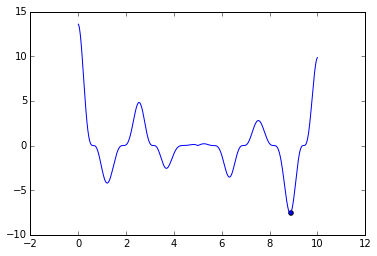

In [18]:
min_x = find_minimum()
print min_x, f(min_x)
y = f(x)
plt.plot(x, y)
plt.scatter(min_x, f(min_x))
print STEPS

#Combinatorial problem

Suppose we have an ordered set of numbers $S = \{x_i\}$ and we want to minimize function:

$$\sum_{i = 0, 2 ..}^{N - 1} |x_i  - x_{i+1}|$$

by changing the order of elements in set S.

In [38]:
N_JOINS = 30

class Element(object):
    def __init__(self, cost):
        self.cost = cost
        #self.penalties = [random.randint(0, 20)] * N_JOINS
    def get_cost(self):
        return self.cost

In [39]:
class Joiner(object):
    
    def __init__(self, elements):
        self.elements = elements
        
    def calculate_cost(self):
        cost = 0
        for i in xrange(0, len(self.elements)-1, 2):
            
            cost += np.abs(self.elements[i].get_cost() - self.elements[i+1].get_cost())
            #print cost
        return cost

In [40]:
elements = [ Element(random.randint(0, 20)) for i in xrange(N_JOINS) ]

In [41]:
joiner = Joiner(elements)
print joiner.calculate_cost()

143


In [42]:
import copy

class Optimizer(object):
    
    def __init__(self, temperature, temp_red_factor, equilibrium_factor):
        self.temperature = temperature
        self.temp_reduction_factor = temp_red_factor
        self.equilibrium_factor = equilibrium_factor
        self.steps_to_equilibrium = 50
        self.current_step = 0
        self.states = []
        
    def find_min(self, sequence):
        """by simulated annealing"""
        self.state = self.random_state(sequence)

        while not self.is_frozen():
            while not self.is_equilibrium():
                new_state = self.random_move(sequence)
                if (self.acceptable(new_state)):
                    self.state = copy.deepcopy(new_state)
            self.states.append(copy.deepcopy(self.state))
            self.reduce_temperature()
        return self.state
    
    def random_state(self, sequence):
        random.shuffle(sequence)
        return sequence
    
    def is_frozen(self):
        return self.temperature < 0.1

    def is_equilibrium(self):
        self.current_step += 1
        return self.current_step % self.steps_to_equilibrium == 0
    
    def random_move(self, sequence):
        return self.random_state(sequence)
    
    def acceptable(self, new_state):
        p = random.random()
        old_cost = Joiner(self.state).calculate_cost()
        new_cost = Joiner(new_state).calculate_cost()
        if new_cost < old_cost:
            return True
        elif self.acc_func(old_cost, new_cost) > p:
            #print 'acc(,) = ', self.acc_func(old_cost, new_cost)
            return True
        else:
            return False
    
    def acc_func(self, x, new_x):
        #print x, new_x, self.temperature
        return np.exp( (x - new_x)/self.temperature )
    
    def reduce_temperature(self):
        self.temperature *= self.temp_reduction_factor

In [43]:
optimizer = Optimizer(temperature=100, temp_red_factor=0.995, equilibrium_factor=0)
optimized_order = optimizer.find_min(elements)
print "Minimal cost = ", Joiner(optimized_order).calculate_cost()
print "steps: ", optimizer.current_step

Minimal cost =  35
68950


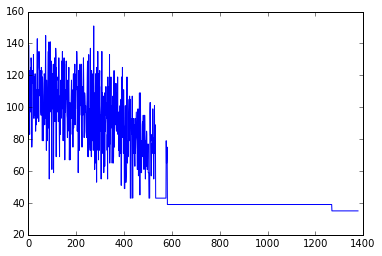

In [44]:
costs = [Joiner(state).calculate_cost() for state in optimizer.states]
plt.plot(costs)
#print costs

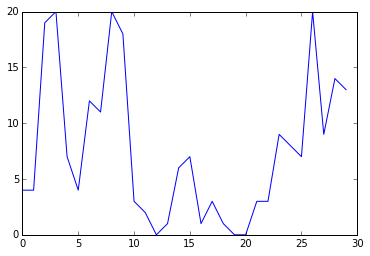

In [45]:
plt.plot([x.get_cost() for x in optimizer.states[-1]])

It can be easily verified how far the algorithm was from the optimial solution

In [48]:
sorted_elements = sorted(elements, key=lambda e:e.get_cost())
cost = Joiner(sorted_elements).calculate_cost()
print "Best result:", cost

Best result: 13
